In [1]:
import numpy as np
from keras.datasets import cifar10
from matplotlib import pyplot as plt
from sys import getsizeof
from memory_profiler import profile
%matplotlib inline

#Load the dataset:
X_train, y_train, X_test, y_test = loadData()
X_train = X_train[:5000]
y_train = y_train[:5000]
X_test = X_test[:2500]
y_test = y_test[:2500]

Using TensorFlow backend.


NameError: name 'loadData' is not defined

In [6]:
print("There are {} train images and {} test images.".format(X_train.shape[0], X_test.shape[0]))
print('There are {} unique classes to predict.'.format(np.unique(y_train).shape[0]))
#One-hot encoding the labels
num_classes = 10
from keras.utils import np_utils
y_train = np_utils.to_categorical(y_train, num_classes)
y_test = np_utils.to_categorical(y_test, num_classes)

There are 50000 train images and 10000 test images.
There are 10 unique classes to predict.


In [14]:
getsizeof(X_train)

(1696, 3264)

Shape of each image in the training data: (32, 32, 3)


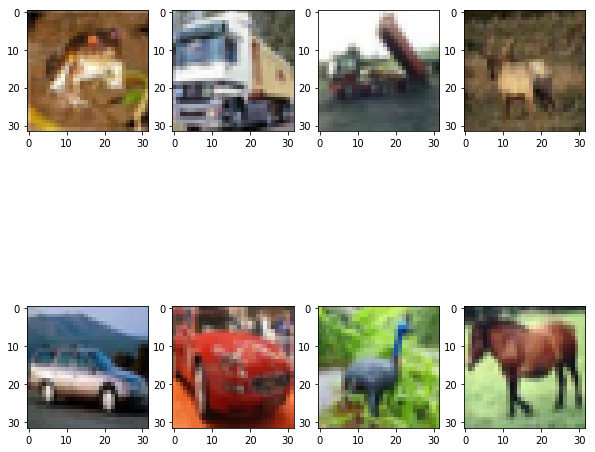

In [16]:
fig = plt.figure(figsize=(10, 10))

for i in range(1, 9):
    img = X_train[i-1]
    fig.add_subplot(2, 4, i)
    plt.imshow(img)

print('Shape of each image in the training data:', X_train.shape[1:])

In [2]:
#Importing the necessary libraries 
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D
from keras.layers import Dropout, Flatten, GlobalAveragePooling2D

#Building up a Sequential model
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu',input_shape = X_train.shape[1:]))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(GlobalAveragePooling2D())
model.add(Dense(10, activation='softmax'))
model.summary()
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

NameError: name 'X_train' is not defined

In [18]:
# X_train_scratch = X_train/255.
# X_test_scratch = X_test/255.

#Creating a checkpointer 
from keras.callbacks import ModelCheckpoint
checkpointer = ModelCheckpoint(filepath='scratchmodel.best.hdf5', verbose=1,save_best_only=True)

#Fitting the model on the train data and labels.
model.fit(X_train, y_train, batch_size=32, epochs=10, verbose=0, callbacks=[checkpointer], validation_split=0.2, shuffle=True)

#Evaluate the model on the test data
score = model.evaluate(X_test, y_test)

#Accuracy on test data
print('Accuracy on the Test Images: ', score[1])


Epoch 00001: val_loss improved from inf to 2.87816, saving model to scratchmodel.best.hdf5

Epoch 00002: val_loss did not improve from 2.87816

Epoch 00003: val_loss did not improve from 2.87816

Epoch 00004: val_loss did not improve from 2.87816

Epoch 00005: val_loss did not improve from 2.87816

Epoch 00006: val_loss did not improve from 2.87816

Epoch 00007: val_loss did not improve from 2.87816

Epoch 00008: val_loss did not improve from 2.87816

Epoch 00009: val_loss did not improve from 2.87816

Epoch 00010: val_loss did not improve from 2.87816
2500/2500 [==============================] - 0s 76us/step
Accuracy on the Test Images:  0.8188800190925598


In [19]:
#Importing the ResNet50 model
from keras.applications.resnet50 import ResNet50, preprocess_input
from skimage.transform import resize

#Loading the ResNet50 model with pre-trained ImageNet weights
model = ResNet50(weights='imagenet', include_top=False, input_shape=(200, 200, 3))


In [20]:
# temp = X_train[-10:-1]
# temp.shape

In [21]:
#Reshaping the training data
X_train_new = [] 
for i in range(X_train.shape[0]):
    X_train_new.append(resize(X_train[-1], (200,200,3)))
    if i>1:
        X_train = X_train[:-1]
X_train = None
X_train_new = np.asarray(X_train_new)

In [22]:

X_train_new = np.asarray(X_train_new)

In [23]:
#Preprocessing the data, so that it can be fed to the pre-trained ResNet50 model. 
resnet_train_input = preprocess_input(X_train_new)
# X_train_new = None

#Creating bottleneck features for the training data
train_features = model.predict(resnet_train_input)
# resnet_train_input = None

#Saving the bottleneck features
np.savez('resnet_features_train', features=train_features)

#Reshaping the testing data
X_test_new = np.array([resize(X_test[i], (200, 200, 3)) for i in range(0, len(X_test))]).astype('float32')


In [24]:

#Preprocessing the data, so that it can be fed to the pre-trained ResNet50 model.
resnet_test_input = preprocess_input(X_test_new)
# X_test_new = None

#Creating bottleneck features for the testing data
test_features = model.predict(resnet_test_input)
# resnet_test_input = None

#Saving the bottleneck features
np.savez('resnet_features_test', features=test_features)

model = Sequential()
model.add(GlobalAveragePooling2D(input_shape=train_features.shape[1:]))
model.add(Dropout(0.3))
model.add(Dense(10, activation='softmax'))
model.summary()
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_4 ( (None, 2048)              0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 10)                20490     
Total params: 20,490
Trainable params: 20,490
Non-trainable params: 0
_________________________________________________________________


In [25]:
model.fit(train_features, y_train, batch_size=32, epochs=10, validation_split=0.2, callbacks=[checkpointer], verbose=1, shuffle=True)
#Evaluate the model on the test data
score  = model.evaluate(test_features, y_test)

#Accuracy on test data
print('Accuracy on the Test Images: ', score[1])

Train on 4000 samples, validate on 1000 samples
Epoch 1/10
4000/4000 [==============================] - 15s 4ms/step - loss: 2.3654 - acc: 0.0990 - val_loss: 2.3093 - val_acc: 0.1090

Epoch 00001: val_loss improved from 2.87816 to 2.30926, saving model to scratchmodel.best.hdf5
Epoch 2/10
4000/4000 [==============================] - 3s 676us/step - loss: 2.3488 - acc: 0.0932 - val_loss: 2.3356 - val_acc: 0.0990

Epoch 00002: val_loss did not improve from 2.30926
Epoch 3/10
4000/4000 [==============================] - 2s 623us/step - loss: 2.3438 - acc: 0.1015 - val_loss: 2.3156 - val_acc: 0.1090

Epoch 00003: val_loss did not improve from 2.30926
Epoch 4/10
4000/4000 [==============================] - 3s 628us/step - loss: 2.3396 - acc: 0.0985 - val_loss: 2.3211 - val_acc: 0.1030

Epoch 00004: val_loss did not improve from 2.30926
Epoch 5/10
4000/4000 [==============================] - 2s 615us/step - loss: 2.3369 - acc: 0.0965 - val_loss: 2.3358 - val_acc: 0.0850

Epoch 00005: val_los